# Object Detection (Part 2 - Model Results)

## Introduction

This `.ipynb.` notebook is created to document the results of my self-study in the topic of `object detection`.<br>
In the previous part, I demonstrated a complete coding cycle for solving object detection problems, starting with dataset preparation, model creation, training, and finally exporting the model. 

In this part, I will illustrate how the YOLO model detects objects and visualizes their locations in images, and explain the post-processing steps necessary when applying to new images.

# Programing

In [1]:
import sys
sys.dont_write_bytecode = True

## Configuration

In [2]:
CFG = {
    "h5file": "export model\YOLOv3_320x320_a1_1Class.h5",
    "dataset_dir": "D:\Github Public\DATASET MANAGER\ObjectDetection (Poor detection)",
    "extenstions": [".jpg", ".png"],
    "label": ["Face"],
    "image_size": 320,
}

## Function declaration

### Image processing

In [3]:
import tensorflow as tf

def image_preprocessing(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, expand_animations=False)
    image = tf.image.resize(
        image, 
        (CFG["image_size"], CFG["image_size"]),
        preserve_aspect_ratio=True,
        antialias=True,
    )
    image = tf.image.resize_with_pad(image, CFG["image_size"], CFG["image_size"])
    image = image / 255.0
    
    return image

### Tensor decoder

The implemented model outputs a tensor of shape `(batch, grid_x, grid_y, anchor, data)`, where the `data` contains information `(confidence_score, x_center, y_center, width, height, class_prob1, class_prob2, ...)` at `(grid_x, grid_y, anchor)` for each image in the batch.

To understand the meaning of the output tensor, it needs to be decoded into three tensors:
- **Confidence Score:** `(confidence_score)` of shape `(batch,)`
- **Boundary Box Coordinates:** `(x_center, y_center, width, height)` of shape `(batch, 4,)`
- **Class Predictions:** `(class_prob1, class_prob2, ...)` of shape `(batch, num_class,)`

Before decoding the tensor, the information for `confidence_score`, `x_center`, and `y_center` needs to undergo preprocessing:
- Update the coordinates `x_center` and `y_center`, which represent the corresponding grid cell `(grid_x, grid_y)`, to `new_x_center = x_center + grid_x` and `new_y_center = y_center + grid_y`, which are coordinates of the image.
- The `confidence_score` needs to be overwritten to `-3`※ if the boundary box is invalid (i.e., one of the values is negative). In explanation, if the coordinates `x_center` and `y_center` are negative, it means the center point is located outside the grid cell. While if the `width` and `height` are negative, it is impossible to have a box with negative sizes.

※ `Sigmoid(-3) = 0.04`

In [4]:
import numpy as np

def decoder(tensor, batch=True):
    # Pre-processing
    # Check for invalid boxes and update raw confidence score = -3
    tensor_np = tensor.numpy()
    invalid_boxes = np.any((tensor_np[..., 1:5] < 0) | (tensor_np[..., 1:5] > 1), axis=-1)
    tensor_np[invalid_boxes, 0] = -3 # Sigmoid(-3) = 0.04

    # Update x_center and y_center to determine the grid coordinate containing the object
    if batch:
        _, row_indices, col_indices, _ = np.indices(tensor.shape[:-1])
    else:
        row_indices, col_indices, _ = np.indices(tensor.shape[:-1])
    tensor_np[..., 1] += col_indices
    tensor_np[..., 2] += row_indices
    tensor = tf.constant(tensor_np, dtype=tensor.dtype)

    # Start decoding
    if batch:
        batch, _, _, _, data = tensor.shape # grid_x, grid_y, anchor
        tensor = tf.reshape(tensor, [batch, -1, data])
    else:
        _, _, _, data = tensor.shape # grid_x, grid_y, anchor
        tensor = tf.reshape(tensor, [-1, data])
    confidence_score = tensor[..., 0]
    box_coordinate = tensor[..., 1:5]
    class_prob = tensor[..., 5:]
    return confidence_score, box_coordinate, class_prob

### Boundary box converter

This utility converts the boundary box from the model output from the format `(x_center, y_center, width, height)` to the format `(y_min, x_min, y_max, x_max)`. This format is compatible with the non-max suppression function `tf.image.non_max_suppression()`.

In [5]:
def xywh2yxyx(image, xywh_box, row_size, col_size):
    row_image, col_image = image.shape[:2]
    
    # Convert box information from grid coordinates to image coordinates
    x_center = xywh_box[:, 0] * col_image / col_size
    y_center = xywh_box[:, 1] * row_image / row_size
    width  = xywh_box[:, 2] * col_image
    height = xywh_box[:, 3] * row_image

    # Convert from (x,y,w,h) to (y,x,y,x) format
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2

    yxyx_box = tf.stack([y_min, x_min, y_max, x_max], axis=-1)
    yxyx_box = tf.cast(yxyx_box, dtype=tf.int32)

    return yxyx_box

### Draw image with grid

In [6]:
import cv2
import math

def draw_grid(image, row_grid_size, col_grid_size):
    # Extract variables
    image_height, image_width = image.shape[:2]

    # Boundary box setup
    grid_color = (0, 0, 255)  # Blue for grid lines
    grid_thickness = 1

    cell_width = image_width // col_grid_size
    cell_height = image_height // row_grid_size

    # Draw vertical lines
    for i in range(col_grid_size):
        x = i * cell_width
        cv2.line(image, (x, 0), (x, image.shape[0]), grid_color, grid_thickness)

    # Draw horizontal lines
    for i in range(row_grid_size):
        y = i * cell_height
        cv2.line(image, (0, y), (image.shape[1], y), grid_color, grid_thickness)

def draw_bounding_box(image, confidence_score, yxyx_box, class_name):
    # Extract box information
    y_min, x_min, y_max, x_max = yxyx_box.numpy()

    # Boundary box setup
    color = (0, 255, 0)  # Green for the bounding box color
    thickness = 2

    # Draw boundary box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)

    # Draw text with class name and confidence score
    text = f"{class_name} ({confidence_score:.2f})"
    cv2.putText(image, text, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)


def draw_highlight(image, xywh_box, row_size, col_size):
    # Extract variables
    image_height, image_width = image.shape[:2]

    x, y, _, _ = xywh_box.numpy()
    row, col = math.floor(y), math.floor(x)

    # Calculate grid cell coordinates in image
    x_center_image = (col + x - col) * image_width / col_size
    y_center_image = (row + y - row) * image_height / row_size

    # Calculate grid coordinates
    cell_width = image_width // col_size
    cell_height = image_height // row_size
    grid_x_min, grid_y_min = col * cell_width, row * cell_height
    grid_x_max, grid_y_max = (col + 1) * cell_width, (row + 1) * cell_height

    # Draw grid bounding box
    color = (255, 0, 0)  # Red grid lines
    thickness = 1
    cv2.rectangle(image, (grid_x_min, grid_y_min), (grid_x_max, grid_y_max), color, thickness)

    # Draw dots at x_center and y_center
    dot_radius = 2
    dot_color = (255, 0, 0)  # Red dots
    x_center_pixel, y_center_pixel = int(x_center_image), int(y_center_image)
    cv2.circle(image, (x_center_pixel, y_center_pixel), dot_radius, dot_color, -1)

## Load image path and model

In [7]:
from model.ImportModel import ImportModel
from module.utility.DirectoryProcessor import DirectoryProcessor

yolo = ImportModel(CFG["h5file"])
path_list = DirectoryProcessor.get_only_files(CFG["dataset_dir"], CFG["extenstions"], include_sub_dir=False)

Loading model ...
Model loaded successfully. No custom Keras layers detected.


## Displaying results without Non-Maximum Suppression

In this section, we will visualize the detection results of the YOLOv3 model, considering that the model produces outputs at three different scales.

ic| number_random: 413


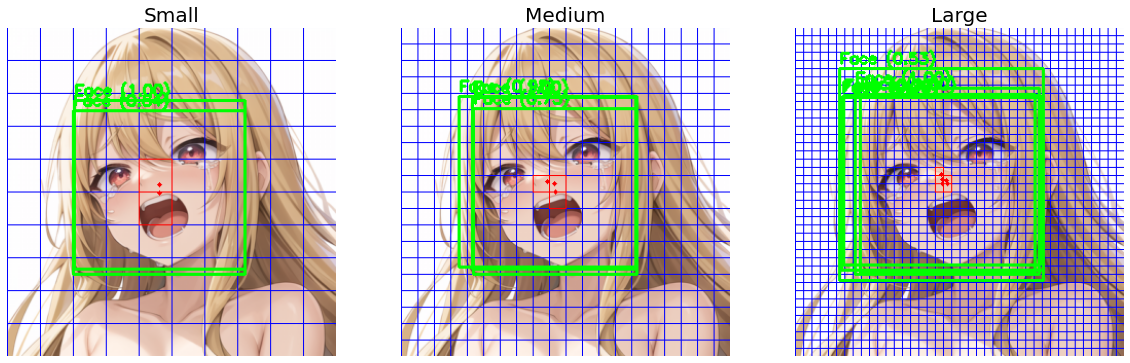

In [8]:
import matplotlib.pyplot as plt
import random
from icecream import ic

def show_result_without_nms(image):
    # Predic result
    title = ["Small", "Medium", "Large"]
    small, medium, large = yolo.predict(tf.expand_dims(image, axis=0))
    scale_list = [tf.constant(scale) for scale in [small, medium, large]]

    image = np.clip(image, 0, 1)
    image = (image * 255).astype("uint8")

    # Show result
    plt.figure(figsize=(20,10))
    for scale_idx, scale_output in enumerate(scale_list):
        plt.subplot(1,3, scale_idx+1)
        _, row_size, col_size, _, _ = scale_output.shape

        # Decode output tensor
        pred_obj, pred_box, pred_class = decoder(scale_output)
        pred_obj = tf.math.sigmoid(pred_obj)
        pred_class = tf.math.softmax(pred_class)    
        
        batch_size = pred_obj.shape[0]

        for i in range(batch_size):

            image_with_box = image.copy()
            
            # Convert box from (x,y,w,h) to (y,x,y,x) format
            yxyx_box = xywh2yxyx(image_with_box, pred_box[i], row_size, col_size)

            draw_grid(image_with_box, row_size, col_size)

            for idx in range(pred_obj[i].shape[0]):
                confidence_score = pred_obj[i,idx].numpy()
                if confidence_score > 0.5:
                    class_idx = tf.argmax(pred_class[i,idx])
                    class_name = CFG["label"][class_idx]
                    draw_bounding_box(image_with_box, confidence_score, yxyx_box[idx], class_name)
                    draw_highlight(image_with_box, pred_box[i,idx], row_size, col_size)

        plt.title(title[scale_idx], fontsize=20)
        plt.imshow(image_with_box)                 
        plt.axis("off")

number_random = random.randint(0, len(path_list))
ic(number_random)
image = image_preprocessing(path_list[number_random])

show_result_without_nms(image)

The results show that multiple bounding boxes are present in each detection scale, making them unsuitable for practical application. Thus, additional processing steps are needed to filter and to refine these boxes.

## Displaying results with Non-Maximum Suppression

In the following section, I will demonstrate how to refine and filter these results using non-maximum suppression.

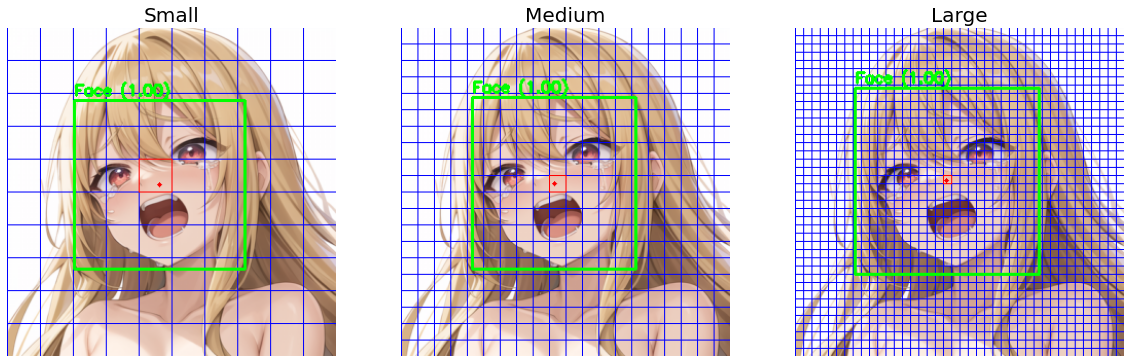

In [9]:
def show_result_with_nms(image):
    # Predic result
    title = ["Small", "Medium", "Large"]
    small, medium, large = yolo.predict(tf.expand_dims(image, axis=0))
    scale_list = [tf.constant(scale) for scale in [small, medium, large]]

    image = np.clip(image, 0, 1)
    image = (image * 255).astype("uint8")
    
    # Show result
    plt.figure(figsize=(20,10))
    for scale_idx, scale_output in enumerate(scale_list):
        plt.subplot(1,3, scale_idx+1)
        _, row_size, col_size, _, _ = scale_output.shape

        # Decode output tensor
        pred_obj, pred_box, pred_class = decoder(scale_output)
        pred_obj = tf.math.sigmoid(pred_obj)
        pred_class = tf.math.softmax(pred_class)    
        
        batch_size = pred_obj.shape[0]

        for i in range(batch_size):

            image_with_box = image.copy()
            
            # Convert box from (x,y,w,h) to (y,x,y,x) format
            yxyx_box = xywh2yxyx(image_with_box, pred_box[i], row_size, col_size)

            # Applying non-max suppression
            selected_indices = tf.image.non_max_suppression(
                tf.cast(yxyx_box, dtype=tf.float32), 
                pred_obj[i], 
                max_output_size=200, 
                score_threshold=0.2,
            )
            selected_indices = selected_indices.numpy().tolist()

            draw_grid(image_with_box, row_size, col_size)

            for idx in selected_indices:
                confidence_score = pred_obj[i,idx].numpy()
                if confidence_score > 0.5:
                    class_idx = tf.argmax(pred_class[i,idx])
                    class_name = CFG["label"][class_idx]
                    draw_bounding_box(image_with_box, confidence_score, yxyx_box[idx], class_name)
                    draw_highlight(image_with_box, pred_box[i,idx], row_size, col_size)

        plt.title(title[scale_idx], fontsize=20)
        plt.imshow(image_with_box)                 
        plt.axis("off")

show_result_with_nms(image)

Comparing the results from the previous section, non-max suppression refines the detection results by filtering overlapping bounding boxes. However, don't forget that this section shows the detection results **FOR EACH OUTPUT SCALE**.

## Merging all detection results and exporting the results

In this section, the procedure in previous section will be repeated. However, I modify the procedure by concatenating the results from all detection scales and apply non-maximum suppression to obtain the most accurate detection results. Finally, the detection results will be exported for using with the original image.

[(0.9994055,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.221875, 0.203125, 0.734375, 0.721875], dtype=float32)>,
  'Face')]

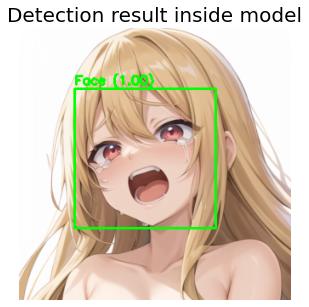

In [10]:
def get_result(image):
    detection_result = []
    # Predic result
    small, medium, large = yolo.predict(tf.expand_dims(image, axis=0))
    scale_list = [tf.constant(scale) for scale in [small, medium, large]]

    batch_size = small.shape[0]
    
    image = np.clip(image, 0, 1)
    image = (image * 255).astype("uint8")
    
    plt.figure(figsize=(5,5))
    for batch_idx in range(batch_size):

        image_height, image_width = image.shape[:2]

        all_obj, all_box, all_class = [], [], []

        # Merging all detection result
        for scale_output in scale_list:
            _, row_size, col_size, _, _ = scale_output.shape
            
            pred_obj, pred_box, pred_class = decoder(scale_output[batch_idx], batch=False)
            pred_obj = tf.math.sigmoid(pred_obj)
            pred_class = tf.math.softmax(pred_class)

            yxyx_box = xywh2yxyx(image, pred_box, row_size, col_size)

            all_obj.append(pred_obj)
            all_box.append(yxyx_box)
            all_class.append(pred_class)

        all_obj = tf.concat(all_obj, axis=0)
        all_box = tf.concat(all_box, axis=0)
        all_class = tf.concat(all_class, axis=0)

        # Applying non-max suppression
        selected_indices = tf.image.non_max_suppression(
            tf.cast(all_box, dtype=tf.float32), 
            all_obj, 
            max_output_size=200, 
            score_threshold=0.2,
        )
        selected_indices = selected_indices.numpy().tolist()

        for idx in selected_indices:
            confidence_score = all_obj[idx].numpy()
            if confidence_score > 0.5:
                class_idx = tf.argmax(all_class[idx])
                class_name = CFG["label"][class_idx]
                draw_bounding_box(image, confidence_score, all_box[idx], class_name)

                y_min, x_min, y_max, x_max = all_box[idx].numpy()
                y_min /= image_height
                x_min /= image_width
                y_max /= image_height
                x_max /= image_width
                
                norm_box = tf.stack([y_min, x_min, y_max, x_max], axis=-1)
                norm_box = tf.cast(norm_box, dtype=tf.float32)
                
                detection_result.append((confidence_score, norm_box, class_name))
        
        plt.title("Detection result inside model", fontsize=20)
        plt.imshow(image)                 
        plt.axis("off")

    return detection_result
get_result(image)

## Post-processing detection results for original images

After decoding the output model and applying non-maximum suppression to obtain the best boundary box detections, the next step is to export the `normalized boundary boxes` for applying on the original image. It is important to note that the entire process, from the start, has been performed on resized images. Now, these refined results are integrated back into the original images.

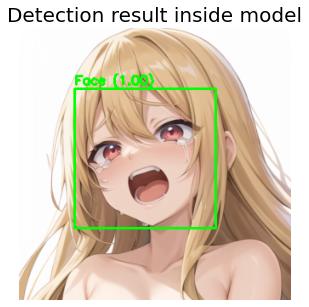

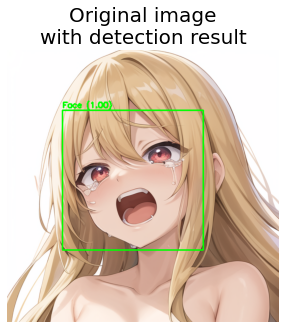

In [11]:
def image_reader(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, expand_animations=False)
    image = image / 255
    return image

def show_detection(image, detection_list):
    image_height, image_width = image.shape[:2]

    image = np.clip(image, 0, 1)
    image = (image * 255).astype("uint8") 

    plt.figure(figsize=(5,5))
    for detection in detection_list:
        confidence_score, box, class_name = detection
        y_min, x_min, y_max, x_max = box.numpy()
        
        y_min *= image_height
        x_min *= image_width
        y_max *= image_height
        x_max *= image_width
        
        box = tf.stack([y_min, x_min, y_max, x_max], axis=-1)
        box = tf.cast(box, tf.int32)
        draw_bounding_box(image, confidence_score, box, class_name)
    plt.title("Original image\nwith detection result", fontsize=20)
    plt.imshow(image)                 
    plt.axis("off")


detection_list = get_result(image)

image_original = image_reader(path_list[number_random])
show_detection(image_original, detection_list)

It seems like the process is complete but not yet. If the original images do not have the same resolution ratio as the input model (in this example, a square image), it may result in incorrect boundary boxes, as illustrated below.

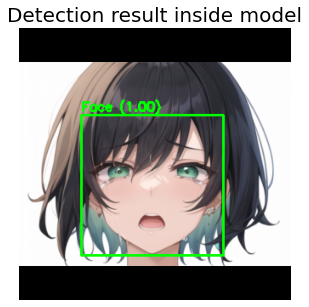

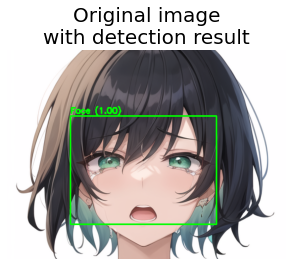

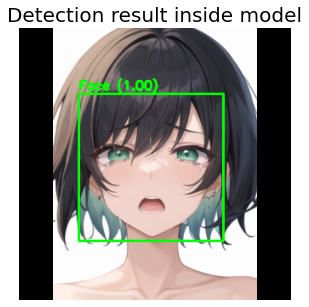

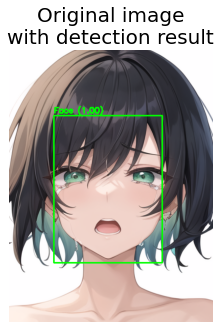

In [12]:
image_hori_path = "samples\\ObjectDetection\\716934876_horizontal_rect.png"
image_vert_path = "samples\\ObjectDetection\\716934876_vertical_rect.png"
image_squa_path = "samples\\ObjectDetection\\716934876_original.png"

# Horizontal image
image_padding = image_preprocessing(image_hori_path)
image_original = image_reader(image_hori_path)
detection_list = get_result(image_padding)
show_detection(image_original, detection_list)

# Vertical image
image_padding = image_preprocessing(image_vert_path)
image_original = image_reader(image_vert_path)
detection_list = get_result(image_padding)
show_detection(image_original, detection_list)

To solve this problem, it is essential to measure both `pad_width` and `pad_height` values and utilize them as offsets when computing new boundary box coordinates. I have modified the `image preprocessing` function to calculate both `pad_width` and `pad_height` and return them as normalized values. Reminding that the boundary boxes include normalized values of `(y_min, x_min, y_max, x_max)`.

In [13]:
def calculate_padding(image, target_resolution):
    # Calculate the aspect ratio of the original image
    original_height, original_width = image.shape[:2]
    aspect_ratio = original_width / original_height

    # Determine whether to resize based on width or height
    if target_resolution / aspect_ratio <= target_resolution:
        # Resize based on width
        new_width = target_resolution
        new_height = int(target_resolution / aspect_ratio)
    else:
        # Resize based on height
        new_width = int(target_resolution * aspect_ratio)
        new_height = target_resolution

    # Calculate padding for both width and height
    pad_width = max(0, target_resolution - new_width)
    pad_height = max(0, target_resolution - new_height)

    pad_width = pad_width // 2 # for both side
    pad_height = pad_height // 2

    # Normalize
    pad_width_norm = pad_width / target_resolution
    pad_height_norm = pad_height / target_resolution

    return (pad_height_norm, pad_width_norm)

def modify_image_preprocessing(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, expand_animations=False)
    image = tf.image.resize(
        image, 
        (CFG["image_size"], CFG["image_size"]),
        preserve_aspect_ratio=True,
        antialias=True,
    )

    # Calculate padding size (top, bottom, left, right)
    padding = calculate_padding(image, CFG["image_size"])

    image = tf.image.resize_with_pad(image, CFG["image_size"], CFG["image_size"])
    image = image / 255.0
    
    return image, padding

Finally, I have modified the `show_detection` function, which displays the detection results with the original size of the input images. The adjustment involves enabling the function to accept the `padding` values and utilizing them as offsets when computing new boundary box coordinates.

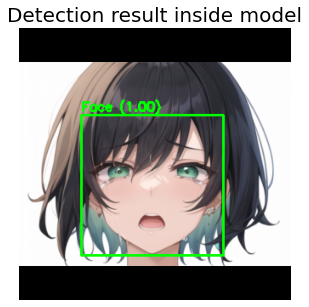

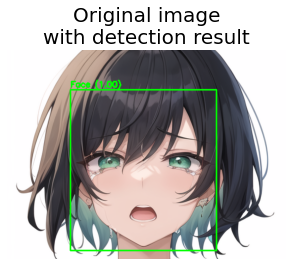

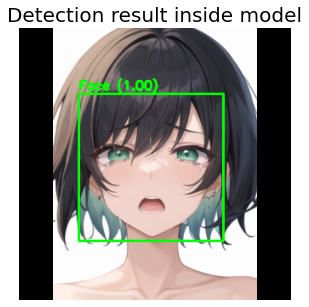

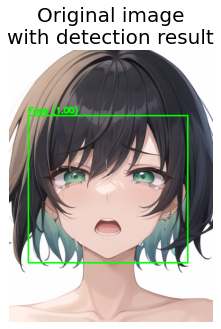

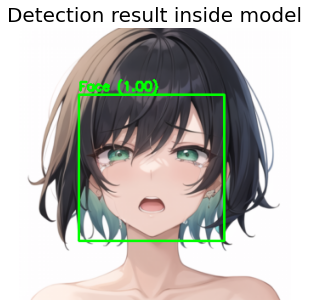

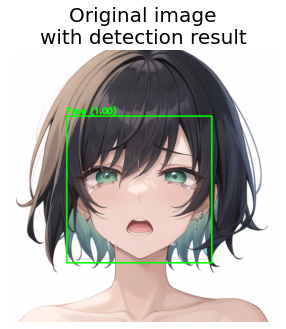

In [14]:
def modify_show_detection(image, padding, detection_list):
    image_height, image_width = image.shape[:2]
    pad_height, pad_width = padding

    image = np.clip(image, 0, 1)
    image = (image * 255).astype("uint8") 

    plt.figure(figsize=(5,5))
    for detection in detection_list:
        confidence_score, box, class_name = detection
        y_min, x_min, y_max, x_max = box.numpy()

        y_min = (y_min - pad_height) * image_height
        x_min = (x_min - pad_width) * image_width
        y_max = (y_max + pad_height) * image_height
        x_max = (x_max + pad_width) * image_width

        box = tf.stack([y_min, x_min, y_max, x_max], axis=-1)
        box = tf.cast(box, tf.int32)
        draw_bounding_box(image, confidence_score, box, class_name)
    plt.title("Original image\nwith detection result", fontsize=20)
    plt.imshow(image)                 
    plt.axis("off")

# Horizontal image
image_padding, padding = modify_image_preprocessing(image_hori_path)
image_original = image_reader(image_hori_path)
detection_list = get_result(image_padding)
modify_show_detection(image_original, padding, detection_list)

# Vertical image
image_padding, padding = modify_image_preprocessing(image_vert_path)
image_original = image_reader(image_vert_path)
detection_list = get_result(image_padding)
modify_show_detection(image_original, padding, detection_list)

# Square image
image_padding, padding = modify_image_preprocessing(image_squa_path)
image_original = image_reader(image_squa_path)
detection_list = get_result(image_padding)
modify_show_detection(image_original, padding, detection_list)

Done!